In [ ]:
!pip install tensorflow_text
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_text
import pandas as pd
import numpy as np
import tensorflow_addons as tfa

## Preprocessing

In [ ]:
# Import dutch sentiment
tweets = pd.read_excel("../../Data/tweets.xlsx")
tweets = tweets[tweets['GR'] != 'unclear']
tweets.head()
embedding = pd.read_pickle("../../Data/embedded_dutch_emoji_groupnr.pkl")

In [ ]:
## Dot mind this
tweets['text_clean'].str.contains('club').sum()

22

In [ ]:
## Dont mind this
df = pd.DataFrame(embedding)
df["iaa"] = tweets["iaa"]

In [ ]:
df.to_csv("dataset_for_rapidminer.csv")

#### See distribution of difficult and easy to annotate tweets|

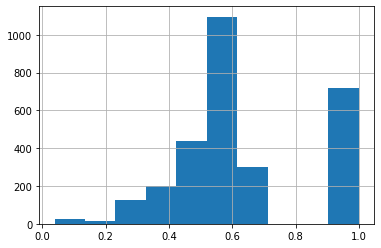

In [ ]:
tweets['iaa'].hist()

#### Set difficult tweet threshold

In [ ]:
tweets['difficult'] = tweets['iaa'] < 0.62

### Calculate weights and initial bias

In [ ]:
difficult = tweets['difficult'].sum()
easy = len(tweets['difficult']) - difficult
print(f"There are {difficult} difficult to annotate tweets and {easy} easy to annotate in the dataset")

In [ ]:
total = len(tweets)
pos = tweets['difficult'].sum()
neg = total - pos

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
initial_bias = np.log([pos/neg])

### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embedding, tweets['difficult'].to_numpy(), 
                                                    test_size=0.2, random_state=42, stratify = tweets['difficult'].to_numpy())

### Neural Network model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu',),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="last_output")
])

Compile model

In [ ]:
metrics = ['accuracy',
          tf.keras.metrics.Recall(name='recall'),
          tfa.metrics.FBetaScore(name='fbeta', beta=2.,num_classes=1, threshold=0.5),
          tf.keras.metrics.AUC(name='prc', curve='PR')
          ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=metrics)

Create save best checkpoint - follows validation fbeta score

In [ ]:
checkpoint_filepath = './model_checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_fbeta',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=25, validation_split=0.15, class_weight=class_weight, callbacks=[model_checkpoint_callback])

Epoch 1/50
80/80 [==============================] - 4s 19ms/step - loss: 0.7489 - accuracy: 0.5154 - recall: 0.5651 - fbeta: 0.5801 - prc: 0.6494 - val_loss: 0.6955 - val_accuracy: 0.3704 - val_recall: 0.2105 - val_fbeta: 0.2439 - val_prc: 0.6855
Epoch 2/50
80/80 [==============================] - 1s 9ms/step - loss: 0.7419 - accuracy: 0.4660 - recall: 0.4188 - fbeta: 0.4500 - prc: 0.6439 - val_loss: 0.7044 - val_accuracy: 0.3191 - val_recall: 0.0445 - val_fbeta: 0.0549 - val_prc: 0.6871
Epoch 3/50
80/80 [==============================] - 1s 9ms/step - loss: 0.7336 - accuracy: 0.4655 - recall: 0.3788 - fbeta: 0.4141 - prc: 0.6566 - val_loss: 0.7023 - val_accuracy: 0.3105 - val_recall: 0.0364 - val_fbeta: 0.0450 - val_prc: 0.6999
Epoch 4/50
80/80 [==============================] - 1s 8ms/step - loss: 0.7344 - accuracy: 0.4997 - recall: 0.4242 - fbeta: 0.4599 - prc: 0.6649 - val_loss: 0.7003 - val_accuracy: 0.3048 - val_recall: 0.0405 - val_fbeta: 0.0498 - val_prc: 0.6968
Epoch 5/50
80/8

In [ ]:
model.load_weights("./model_checkpoint/checkpoint")

### Evaluate model

In [ ]:
test_loss = model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.7414 - accuracy: 0.5342 - recall: 0.6150 - fbeta: 0.6234 - prc: 0.6811


In [ ]:
predicted = model.predict(X_test)

In [ ]:
pred = [elem[0] > 0.5  for elem in predicted]

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

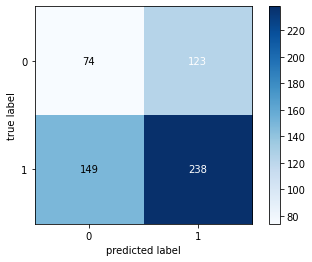

In [ ]:
cf = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=cf, colorbar=True)
plt.show()

#### Save dates

In [ ]:
df = pd.DataFrame({"Truth":y_test, "Pred":pred, "Prob":[prob[0] for prob in predicted]})

In [ ]:
df.to_csv("/content/drive/MyDrive/Thesis/MLAlgorithms/NNModels/resultsNNDutch.csv")

In [ ]:
df

,Truth,Pred,Prob
0,False,True,0.696598
1,False,True,0.772015
2,True,False,0.330871
3,True,True,0.758651
4,True,True,0.834620
...,...,...,...
579,True,True,0.659767
580,True,False,0.422823
581,False,True,0.652479
582,True,True,0.625935
